In [1]:
import pandas as pd
import numpy as np

# 1.Read all the data

In [2]:
Datafile = pd.read_excel('/content/drive/MyDrive/Capstone - Henkel/Data 2/Test Data/Test.xlsx', sheet_name= 'Sheet1')
Country = pd.read_excel('/content/drive/MyDrive/Capstone - Henkel/Data 2/Test Data/Country Codes.xlsx', sheet_name='Sheet1')

In [3]:
# dataset instance
from tabulate import tabulate

view1 = pd.DataFrame(Datafile.head(5))

print("                                                                 -----------Distributor: Darth Vader--------------")
print(tabulate(view1, headers='keys', tablefmt='psql',showindex='False'))

                                                                 -----------Distributor: Darth Vader--------------
+--------------------+--------+---------+---------------+--------------------+--------------------+--------------------------------+-------------------+------------+-------------------------+------------------+---------------------+--------------------------+-----------------------------+----------------------------+
| Transaction Date   |   Year |   Month | Report Date   | Distributor Name   |   SAP Material IDH | SAP Material IDH Description   | Unit of Measure   |   Quantity |   Distributor Unit Cost |   Extended Value | End Customer Name   | SAP End Customer State   |   SAP End Customer Zip Code | SAP End Customer Country   |
|--------------------+--------+---------+---------------+--------------------+--------------------+--------------------------------+-------------------+------------+-------------------------+------------------+---------------------+---------------

# 2.Date Defintion


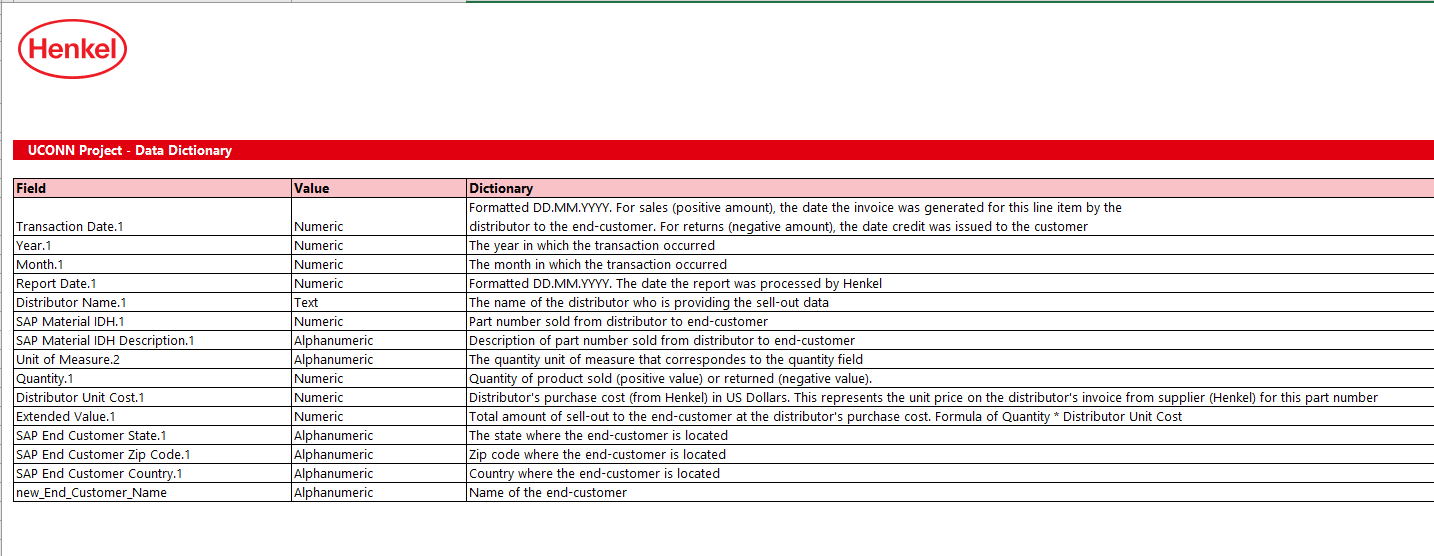

# 3.Cleaning Data

In [4]:
datasets=[] 
string = []

datasets = Datafile
string = ['Datafile']

## 3.1.Merge all Dataset

In [5]:
df = pd.concat([Datafile])

In [6]:
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'] , format='%d.%m.%Y').dt.strftime('%Y-%m-%d')

## 3.2.Missing values


In [7]:
df.isna().sum()

Transaction Date                 0
Year                             0
Month                            0
Report Date                      0
Distributor Name                 0
SAP Material IDH                 0
SAP Material IDH Description     0
Unit of Measure                  0
Quantity                         0
Distributor Unit Cost            0
Extended Value                   0
End Customer Name                0
SAP End Customer State          10
SAP End Customer Zip Code        0
SAP End Customer Country         0
dtype: int64

In [8]:
# changing 'Report' and 'Transaction Date' to datetime format

df['Transaction Date']= pd.to_datetime(df['Transaction Date'])
df['Report Date']= pd.to_datetime(df['Report Date'])
df.dtypes

Transaction Date                datetime64[ns]
Year                                     int64
Month                                    int64
Report Date                     datetime64[ns]
Distributor Name                        object
SAP Material IDH                         int64
SAP Material IDH Description            object
Unit of Measure                         object
Quantity                                 int64
Distributor Unit Cost                  float64
Extended Value                         float64
End Customer Name                       object
SAP End Customer State                  object
SAP End Customer Zip Code               object
SAP End Customer Country                object
dtype: object

In [9]:
df.shape

(650274, 15)

In [10]:
# drop all na's

df = df.dropna()

# with country name
df1 =pd.merge(left=df, right=Country, how='left', left_on='SAP End Customer Country', right_on='Code')
# dropping all nan values
df1 = df1.dropna()

# saving a new dataframe
dftry = df1 

# removing all rows with negative "Extended_ values"
dftry= dftry[dftry['Extended Value'] >= 0]


# dropping the 'code' column
dftry=dftry.drop(columns=['Code'])

In [11]:
dftry.shape

(641122, 16)

In [12]:
#dftry = dftry[dftry['End Customer Name'] != 'Customer 54281']


In [13]:
length = dftry['End Customer Name'].value_counts()
print("Number of distince customer:", length.shape[0])

Number of distince customer: 73734


In [14]:
dftry.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 641122 entries, 0 to 650263
Data columns (total 16 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   Transaction Date              641122 non-null  datetime64[ns]
 1   Year                          641122 non-null  int64         
 2   Month                         641122 non-null  int64         
 3   Report Date                   641122 non-null  datetime64[ns]
 4   Distributor Name              641122 non-null  object        
 5   SAP Material IDH              641122 non-null  int64         
 6   SAP Material IDH Description  641122 non-null  object        
 7   Unit of Measure               641122 non-null  object        
 8   Quantity                      641122 non-null  int64         
 9   Distributor Unit Cost         641122 non-null  float64       
 10  Extended Value                641122 non-null  float64       
 11  End Customer 

# 4.Converting the data with necessary features

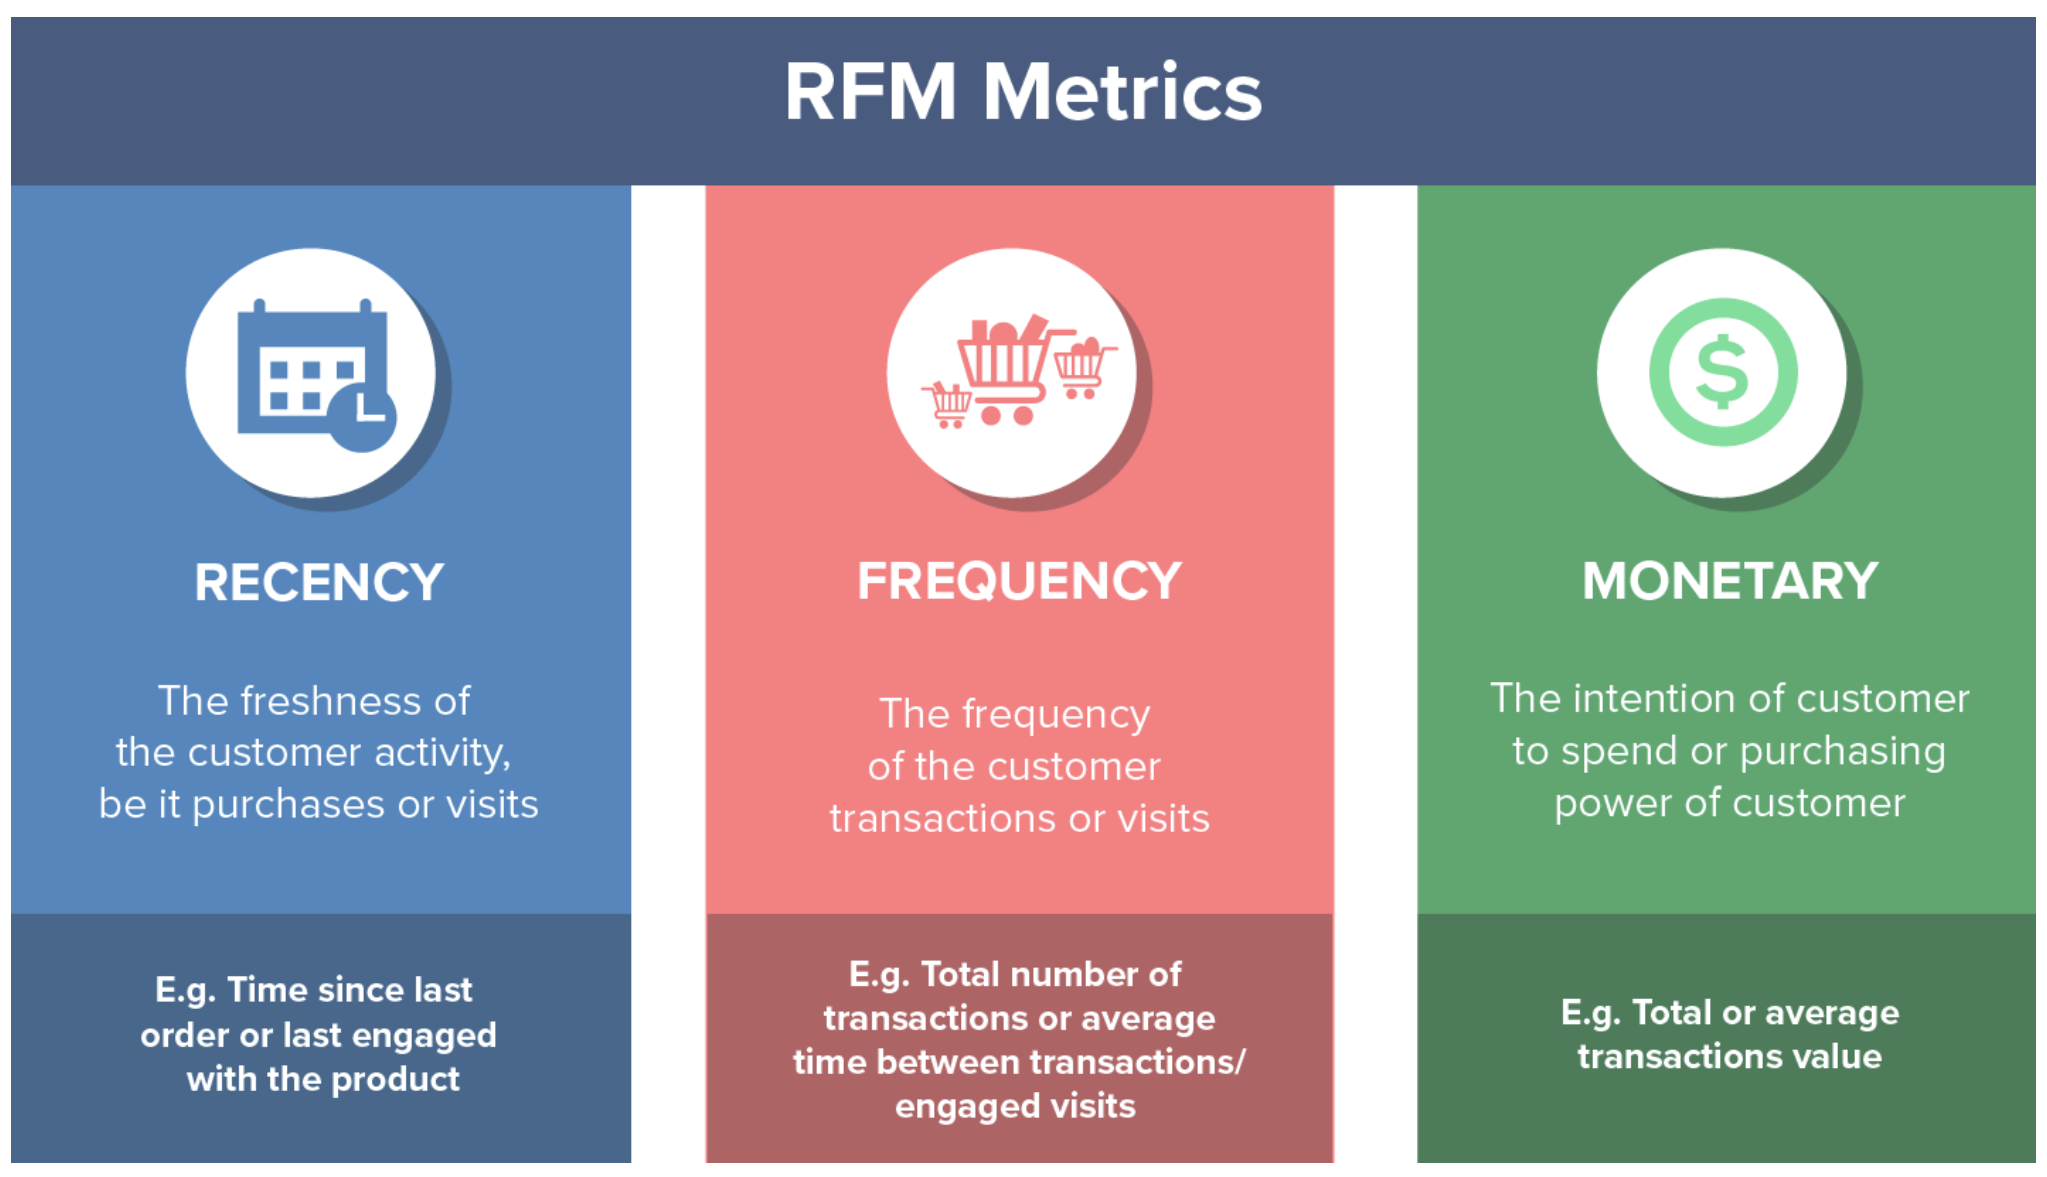

## 4.1.Create RFM table

In [15]:
Latest_order = max(dftry['Transaction Date'])

In [16]:
Latest_order

Timestamp('2020-11-30 00:00:00')

In [17]:
dftry.reset_index(inplace=True)
dftry = dftry.rename(columns = {'index':'Order_id'})

In [18]:
dftry.head(3)

,Order_id,Transaction Date,Year,Month,Report Date,Distributor Name,SAP Material IDH,SAP Material IDH Description,Unit of Measure,Quantity,Distributor Unit Cost,Extended Value,End Customer Name,SAP End Customer State,SAP End Customer Zip Code,SAP End Customer Country,Country/Entity
0,0,2020-01-29,2020,1,2020-04-02,Darth Vader,95633,Garden Valley,EA,98,423.66,41518.68,Customer 34999,NC,27405,US,United States
1,1,2020-01-03,2020,1,2020-04-02,Darth Vader,95940,Feather Falls,CS,1,956.76,956.76,Customer 31255,NC,27205,US,United States
2,2,2020-01-07,2020,1,2020-04-02,Darth Vader,96032,Fort Jones,EA,1,48.35,48.35,Customer 15270,NC,27261,US,United States


In [19]:
# Adding a quarter column using 'transaction date'
dftry['Year-Quarter'] = dftry['Transaction Date'].dt.year.astype(str) + '-Q' + dftry['Transaction Date'].dt.quarter.astype(str)

Since recency is calculated for a point in time and the  dataset last order date is "Latest_order", that is the date we will use to calculate recency.

Set this date to the current day and extract all orders until yesterday.

In [20]:
import datetime as dt   
NOW = dt.datetime(2020,11,30) #YYYY,MM,DD

In [21]:
rfmTable = dftry.groupby('End Customer Name').agg({'Transaction Date': lambda x: (NOW - x.max()).days, # Recency
                                        'Order_id': lambda x: len(x),      # Frequency
                                        'Extended Value': lambda x: x.sum()}) # Monetary Value

rfmTable['Transaction Date'] = rfmTable['Transaction Date'].astype(int)
rfmTable.rename(columns={'Transaction Date': 'recency', 
                         'Order_id': 'frequency', 
                         'Extended Value': 'monetary_value'}, inplace=True)

In [22]:
### gap finding
#gap = dftry.groupby('End Customer Name').agg({'Transaction Date': lambda x: (x.max()- x.min()).days})

# 5.Attrition Prediction

## 5.1 Final Data Preparation

In [23]:
import warnings
warnings.filterwarnings("ignore")

In [24]:
dftry.head(1)

,Order_id,Transaction Date,Year,Month,Report Date,Distributor Name,SAP Material IDH,SAP Material IDH Description,Unit of Measure,Quantity,Distributor Unit Cost,Extended Value,End Customer Name,SAP End Customer State,SAP End Customer Zip Code,SAP End Customer Country,Country/Entity,Year-Quarter
0,0,2020-01-29,2020,1,2020-04-02,Darth Vader,95633,Garden Valley,EA,98,423.66,41518.68,Customer 34999,NC,27405,US,United States,2020-Q1


In [25]:
# creating a dataframe with customer_id and datediffernce between first and last transaction
gap = dftry.groupby('End Customer Name').agg({'Transaction Date': lambda x: (x.max()- x.min()).days,
                                              'Quantity': lambda x: x.sum()})

In [26]:
# creating a dataframe with customer_id, frequency, recency, monetary vaalue and gap(transaction days)
attrition_df = rfmTable[['recency', 'frequency', 'monetary_value']]
attrition_df = attrition_df.reset_index()

gap = gap.reset_index()

attrition_df = pd.merge(left = attrition_df, right= gap, left_on='End Customer Name', right_on= 'End Customer Name')

In [27]:
# renaming the column
attrition_df.rename(columns = {'Transaction Date': 'Transaction days'}, inplace = True)

In [28]:
# removing all the customers with only 1 transaction (Transaction days = 0)
attrition_df = attrition_df[attrition_df['Transaction days']!=0]

# removing all customers who were inactive for last 40 days for better model 
attrition_df = attrition_df[attrition_df['recency']>40]

In [29]:
# creating a new column which describes the average gap betwwn each transactions
attrition_df['Avg_gap_betn_transactions'] = round(attrition_df['Transaction days']/attrition_df['frequency'],1)
attrition_df = attrition_df.iloc[:, attrition_df.columns != 'Avg_gap_betn_transactions']

In [30]:
attrition_df =attrition_df.reset_index(drop=True)

In [31]:
#attrition_df['Churn'] = np.where(attrition_df['recency']> attrition_df['Avg_gap_betn_transactions']+ (2*attrition_df['Avg_gap_betn_transactions']), 1, 0)

In [32]:
abc = attrition_df.copy() # keeping a copy of the dataframe

In [33]:
model_df = attrition_df

In [34]:
Customer_id = model_df[['End Customer Name']]
model_df = model_df.drop(columns='End Customer Name')

In [35]:
import pickle

# Load the Model back from file
Pkl_Filename = "/content/drive/MyDrive/Capstone - Henkel/Data 2/Test Data/Pickle_RL_Model.pkl" 

with open(Pkl_Filename, 'rb') as file:  
    Pickled_LR_Model = pickle.load(file)

Pickled_LR_Model

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=None, verbose=0,
                  warm_start=False)

In [36]:
Ypredict = Pickled_LR_Model.predict(model_df)  
Predictions = pd.DataFrame(Ypredict)


In [37]:
Customer_prediction = Customer_id.merge(Predictions, left_index=True, right_index=True)
Customer_prediction = Customer_prediction.rename(columns = {0: 'Predictions'})
Customer_prediction

,End Customer Name,Predictions
0,Customer 100,1
1,Customer 100008,1
2,Customer 10001,1
3,Customer 100017,1
4,Customer 10003,1
...,...,...
21186,Customer 99957,0
21187,Customer 99973,1
21188,Customer 99976,1
21189,Customer 9998,1


In [38]:
Customer_prediction.to_excel(r'/content/drive/MyDrive/Capstone - Henkel/Data 2/Test Data/Predictions.xlsx', index = False)